# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

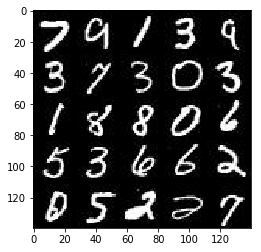

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

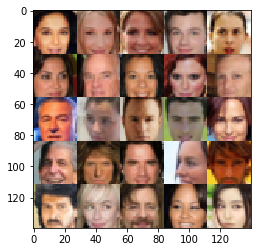

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32,name='lr')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer, 28x28x?
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # scale input image from -0.5 to 0.5 since we are using tanh 
                batch_images = batch_images*2 
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:                
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0080... Generator Loss: 5.4233
Epoch 1/2... Discriminator Loss: 0.1386... Generator Loss: 7.8170
Epoch 1/2... Discriminator Loss: 0.0025... Generator Loss: 11.7976
Epoch 1/2... Discriminator Loss: 0.8165... Generator Loss: 1.5444
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 2.1876
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.8089
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 1.3588


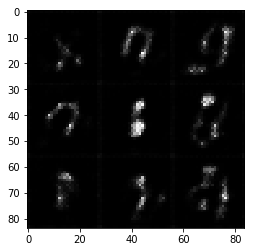

Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.5854
Epoch 1/2... Discriminator Loss: 1.9153... Generator Loss: 0.2009
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.9886
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 1.9007
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.0308


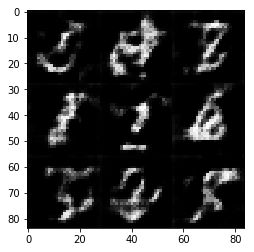

Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 1.4630
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.4676
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.4657
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 1.5688... Generator Loss: 1.9884
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.5281
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 1.4059
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7577


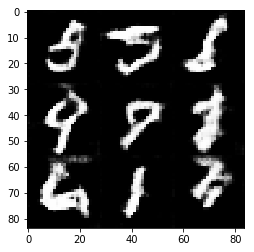

Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.4643
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.9043
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.4420
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 1.5291
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.6728... Generator Loss: 0.2706
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.6556... Generator Loss: 0.2850


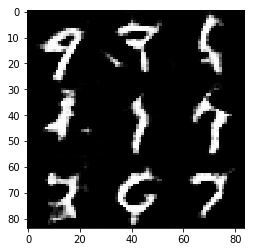

Epoch 1/2... Discriminator Loss: 1.8370... Generator Loss: 2.9085
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.3552
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.5668... Generator Loss: 2.4523
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 0.9650


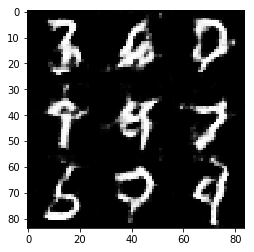

Epoch 1/2... Discriminator Loss: 1.7669... Generator Loss: 0.2434
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.6701
Epoch 1/2... Discriminator Loss: 1.7441... Generator Loss: 0.2618
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.3992
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.5369
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.5730


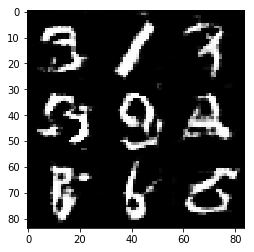

Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 1.4471
Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 0.9806
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.4334
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 2.3342
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.9250


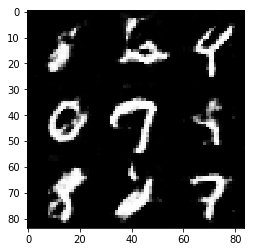

Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.5425
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 1.6813
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.5085
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.6761... Generator Loss: 0.2785


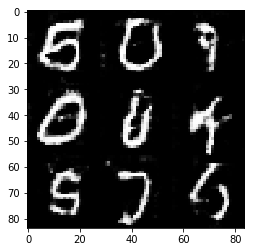

Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 1.8720
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 1.0844
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 1.5303
Epoch 1/2... Discriminator Loss: 2.5916... Generator Loss: 2.4613
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 0.8021


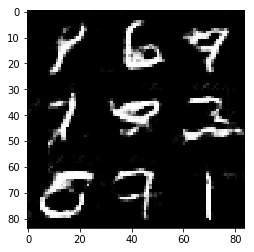

Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 0.8484... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 1.5549... Generator Loss: 1.9708
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 0.8954
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 0.9427


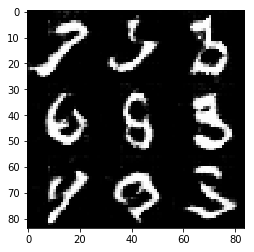

Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.6713... Generator Loss: 0.3076
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.4502
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.9979
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 2.6287
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1042
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.4873
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.4947


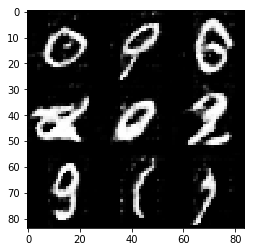

Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.9725... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 0.9863
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.3441
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 2.0766
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.3782
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.4150
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.5447


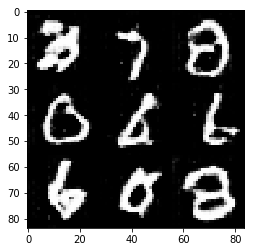

Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 3.4862
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.3578
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.3888
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.1538
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.7234
Epoch 2/2... Discriminator Loss: 1.7076... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 0.5772... Generator Loss: 1.7173


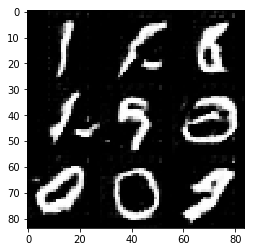

Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.2303
Epoch 2/2... Discriminator Loss: 1.8368... Generator Loss: 0.2489
Epoch 2/2... Discriminator Loss: 0.8664... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.6594


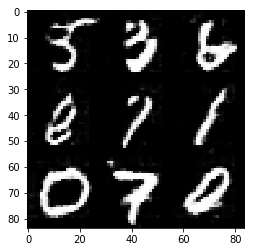

Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.2341
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.3804
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 1.5492
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.4058
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.3760
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 1.0663
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.2375


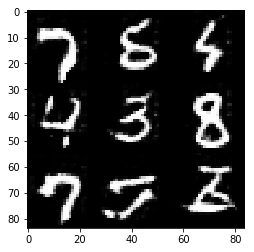

Epoch 2/2... Discriminator Loss: 1.5323... Generator Loss: 0.3421
Epoch 2/2... Discriminator Loss: 0.6379... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 2.5945... Generator Loss: 0.1632
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.3141
Epoch 2/2... Discriminator Loss: 0.8326... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 1.4863
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.0222


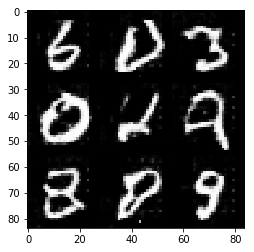

Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 0.8171... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 2.1500
Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 1.3302
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.4682
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 1.5547
Epoch 2/2... Discriminator Loss: 0.4820... Generator Loss: 1.3130


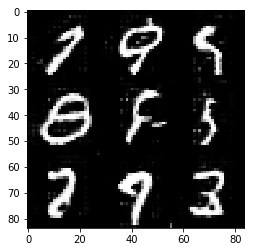

Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 0.3430... Generator Loss: 1.8288
Epoch 2/2... Discriminator Loss: 3.1454... Generator Loss: 5.3008
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.3581
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.7532
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.3501
Epoch 2/2... Discriminator Loss: 1.8163... Generator Loss: 0.2680
Epoch 2/2... Discriminator Loss: 0.5757... Generator Loss: 1.3857


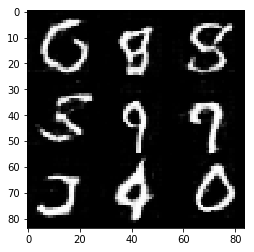

Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 0.4639... Generator Loss: 1.4751
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 2.6908


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 11.9661
Epoch 1/1... Discriminator Loss: 0.0777... Generator Loss: 5.1204
Epoch 1/1... Discriminator Loss: 4.2664... Generator Loss: 0.2594
Epoch 1/1... Discriminator Loss: 0.2596... Generator Loss: 4.3588
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 1.7592
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 5.3363
Epoch 1/1... Discriminator Loss: 0.0477... Generator Loss: 4.7367
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.6324
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 1.9406


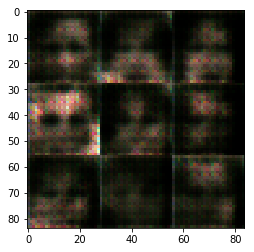

Epoch 1/1... Discriminator Loss: 2.4472... Generator Loss: 0.1330
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 3.4513
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.7290... Generator Loss: 0.3176
Epoch 1/1... Discriminator Loss: 1.6785... Generator Loss: 0.3389
Epoch 1/1... Discriminator Loss: 2.2055... Generator Loss: 0.1646


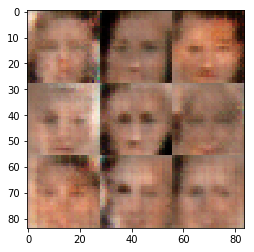

Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 1.4066


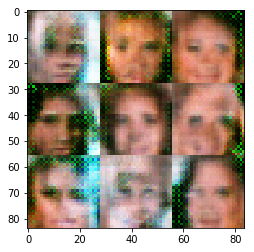

Epoch 1/1... Discriminator Loss: 1.7644... Generator Loss: 0.2723
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 1.9737
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 2.5753
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.4963


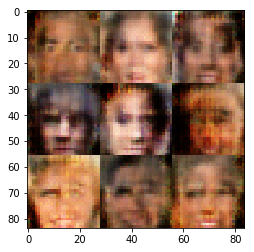

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 2.2807... Generator Loss: 3.0779
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 5.3789
Epoch 1/1... Discriminator Loss: 1.6692... Generator Loss: 0.2814
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.1027


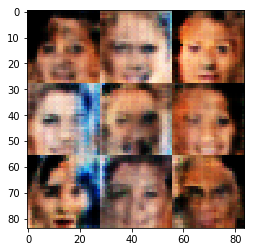

Epoch 1/1... Discriminator Loss: 3.1633... Generator Loss: 4.5352
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 2.5684... Generator Loss: 2.6488
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.2146


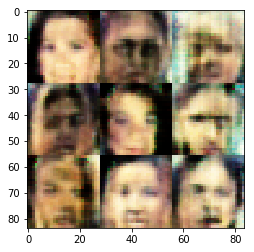

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.2283
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.2797
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 2.1289
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.7019
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.3971


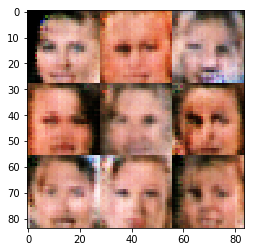

Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 2.0537... Generator Loss: 0.1764
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.3616


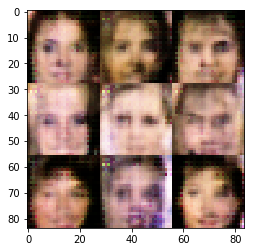

Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 2.0448
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.3391


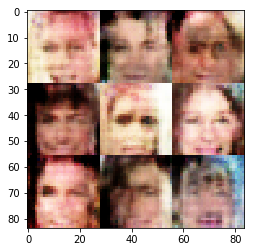

Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 2.4222
Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.2653


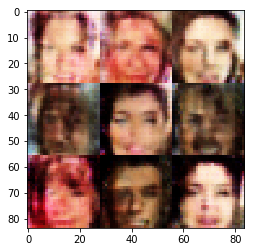

Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.2831
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.3232


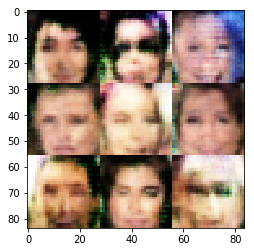

Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.3630
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 1.8271
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 1.9499
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.4254


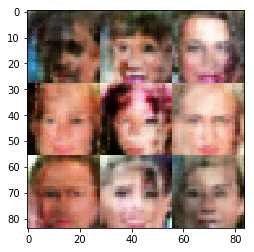

Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.5393


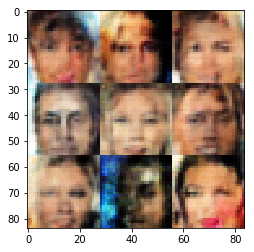

Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 2.0991... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7409


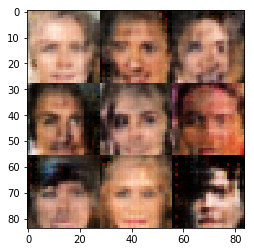

Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 2.0968


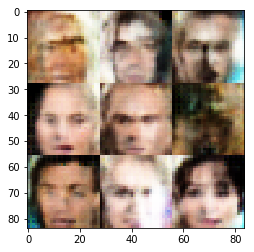

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.4113
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.3647
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6053


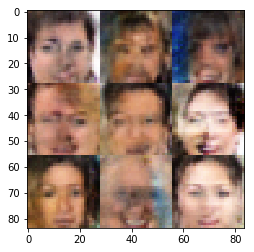

Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.6370... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 2.0596... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6385


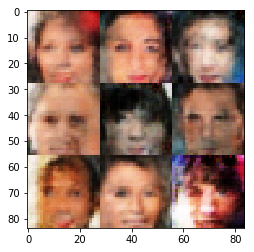

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.3513
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8138


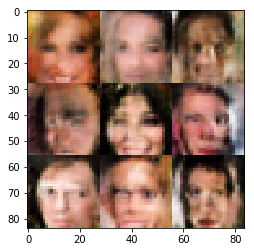

Epoch 1/1... Discriminator Loss: 1.6370... Generator Loss: 1.8041
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.2934
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.2880
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8541


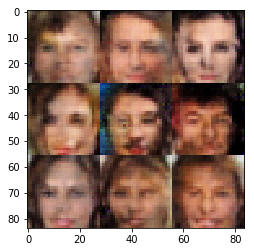

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.8117... Generator Loss: 0.2312
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.4999


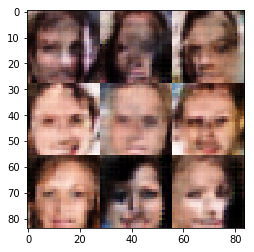

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6932


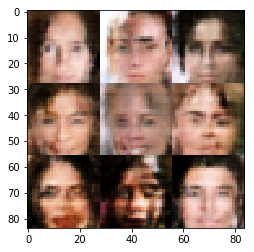

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.9185... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.3709


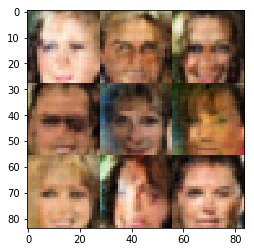

Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4245


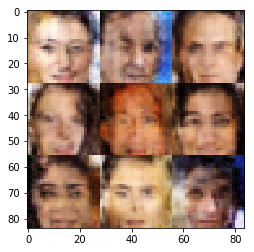

Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.4350


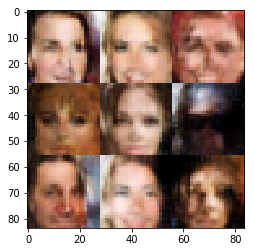

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8744


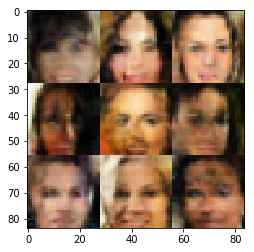

Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.8756


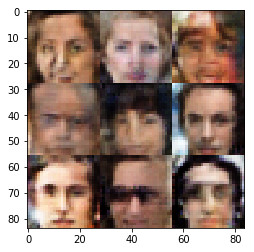

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7184


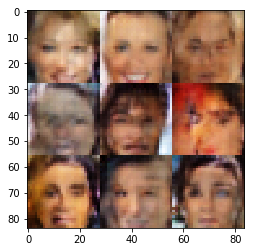

Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.9265


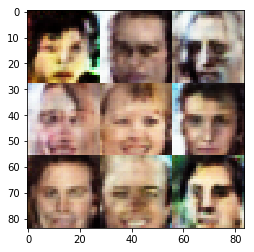

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6624


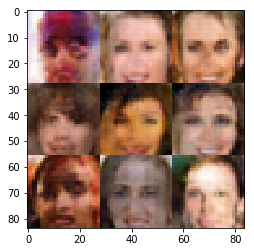

Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5357


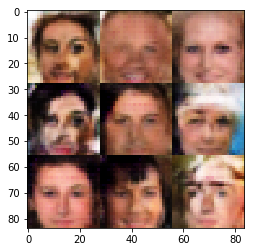

Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6695


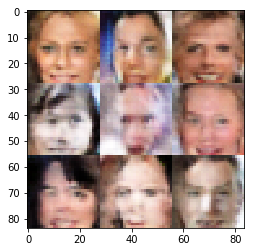

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6780


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.